# Introduction to Chaotic Amplitude Control (CAC) in CIM

## Load the Liberaries

In [25]:
# Initialization and Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
project_root = Path.cwd().parent  
sys.path.append(str(project_root)) 
from src.Optimise_param import *
from src.AHC import *

## Create the Mobius Ladder

[[ 0. -1.  0.  0. -1.  0.  0. -1.]
 [-1.  0. -1.  0.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  0.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  0.  0. -1.]
 [-1.  0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1.  0.  0. -1.  0. -1.  0.]
 [ 0.  0. -1.  0.  0. -1.  0. -1.]
 [-1.  0.  0. -1.  0.  0. -1.  0.]]


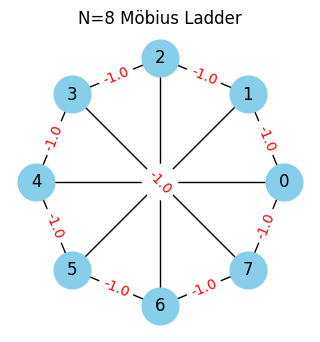

In [26]:
import networkx as nx

# Initialize the J matrix for the Möbius ladder with zeros
J_mobius = np.zeros((8, 8))

# Set the nearest neighbor interactions and the "rung" interactions
for i in range(8):
    J_mobius[i, (i-1) % 8] = -1  # Interaction with the previous spin
    J_mobius[i, (i+1) % 8] = -1  # Interaction with the next spin
    if i < 4:  # "Rung" interactions, avoiding duplicate entries
        J_mobius[i, (i+4) % 8] = -1
        J_mobius[(i+4) % 8, i] = -1  # Ensure the matrix is symmetric

print(J_mobius)

# Initialize a new graph for the Möbius ladder based on the J-matrix
G_J_mobius = nx.Graph()

# Add nodes to the graph
for i in range(8):
    G_J_mobius.add_node(i)

# Add edges based on the J-matrix, considering only the upper triangle to avoid duplicates
for i in range(8):
    for j in range(i+1, 8):
        if J_mobius[i, j] != 0:
            G_J_mobius.add_edge(i, j, weight=J_mobius[i, j])

# Draw the graph with a circular layout to represent the Möbius ladder structure
pos_J_mobius = nx.circular_layout(G_J_mobius)  # Use a circular layout for the nodes

plt.figure(figsize=(3, 3))
nx.draw(G_J_mobius, pos_J_mobius, with_labels=True, node_color='skyblue', node_size=700, edge_color='black')
edge_labels = nx.get_edge_attributes(G_J_mobius, 'weight')
nx.draw_networkx_edge_labels(G_J_mobius, pos_J_mobius, edge_labels=edge_labels, font_color='red')
plt.title("N=8 Möbius Ladder")
plt.show()


# Define the Brute Force Function

In [27]:
import copy
def get_binary_list(num, length):
    """Converts a number into a binary list (spin configuration) of a given length."""
    bit_string = "{0:b}".format(num)
    num_str_len = len(bit_string)
    num_list = np.zeros(length)
    if num == 0:
        return num_list
    filled_string = (length - num_str_len) * '0' + bit_string
    return list(map(int, filled_string))


def brute_force(J, h=None):   
    Ising_list = []          
    """Basic brute-force solver for confirming ground state energy of smaller Ising problems."""
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    min_energy = 1e20
    for z in range(2**N):
        spins = np.array(get_binary_list(z, N))
        spins = 2 * (spins > 0) - 1
        ising_energy = -1/2*(J.dot(spins)).dot(spins) - h.dot(spins)
        Ising_list.append(ising_energy)

        if ising_energy < min_energy:
            min_energy = ising_energy
            opt_spins = copy.deepcopy(spins)
    return opt_spins, min_energy, Ising_list

In [28]:
spins_ground, E_ground, Ising_list = brute_force(J_mobius)

print("The spin configuration in the ground state is {}".format(spins_ground))
print("The ground energy is {}".format(E_ground))

The spin configuration in the ground state is [-1 -1  1 -1  1  1 -1  1]
The ground energy is -8.0


### Visualize the Brute Force Results

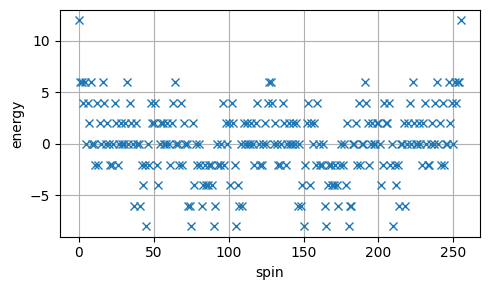

In [29]:
spin = range(2**8)
plt.figure(figsize=(5, 3))
plt.plot(spin, Ising_list, 'x')
plt.xlabel('spin')
plt.ylabel('energy')
plt.grid()
plt.tight_layout()
plt.show()

# Try CIM algorithm

In [30]:
eps_0 = 0.2
r_0 = 0.07
results = CIM_AHC_GPU(T_time=20, 
                      J=J_mobius, 
                      batch_size=1, 
                      time_step=0.01, 
                      custom_fb_schedule=None, 
                      custom_pump_schedule=None)
                      

spin_config, x_trajectory, t, energy_plot_data, error_var_data, divg, kappa = results


### Metadata and internal dynamics of the CIM

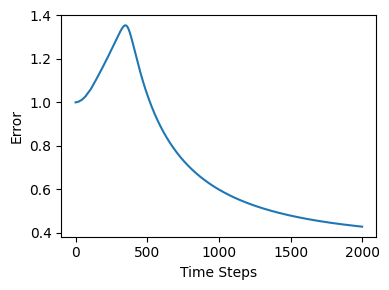

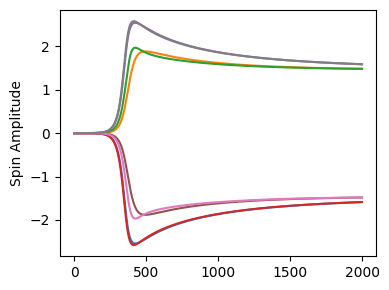

Energy reaches a steady state at: 106


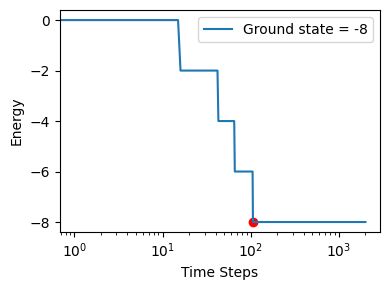

In [33]:
# Plotting the error over time
plt.figure(figsize=(4, 3))
plt.plot(error_var_data[0][0])
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

# Plotting spin amplitude for each of the first 50 spins
plt.figure(figsize=(4, 3))
for spin_index in range(8):
    plt.plot(np.arange(t+1), x_trajectory[0, spin_index, :])
plt.ylabel('Spin Amplitude')
plt.tight_layout()
plt.show()

energy_trace = energy_plot_data[0]
min_energy = np.min(energy_trace)
# Find the index of the first occurrence of the minimum energy
first_min_index = np.where(energy_trace == min_energy)[0][0]

threshold = 10  # Define a small threshold value
period = 5  # Period to check for stability
if all(abs(energy_trace[first_min_index + i] - min_energy) < threshold for i in range(period)):
    print("Energy reaches a steady state at:", first_min_index)
else:
    print("Energy reaches the lowest value at:", first_min_index, "but doesn't remain stable for the next", period, "steps.")

# Plotting the point where energy reaches steady state
plt.figure(figsize=(4, 3))
plt.plot(energy_trace, label=f'Ground state = {min_energy:.0f}')
plt.scatter(first_min_index, min_energy, color='red')  # Mark the steady state point
plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()
